# LOCAL SEARCH - ANÁLISE DE RESULTADOS

 - ITA | PG-CTE-S | TE-282 - Meta-heurísticas
 - Professor Dr. Angelo Passaro
 - Aluno: Rafael Caneiro de Oliveira
 - Versao: 0.1
 - Data: 26/10/2021

## Bibliotecas | Parâmetros | Funções

In [99]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
from ast import literal_eval
from tqdm.auto import tqdm
import ray
import os

PATH = Path.cwd().parent
RAW_PATH = Path(PATH, "./data/raw/") 
LOG_PATH = Path(PATH, "./data/log/")
print(LOG_PATH)


/Users/rco/github/s_metaheuristic/data/log


In [100]:
def read_port_files(n_port):
    filepath = Path(RAW_PATH, 'port' + str(n_port) + '.txt')
    with open(filepath) as fp:
        # quantidade de ativos no portfolio
        n_assets = int(fp.readline())
        # armazena as estatisticas do ativo
        r_mean = []
        r_std = []
        for n in range(n_assets):
            line = fp.readline()
            r_mean.append(float(line.strip().split()[0]))
            r_std.append(float(line.strip().split()[1]))

        # obtem o restante da matriz de covariancia
        cnt = 32
        i = []
        j = []
        cov = []
        line = fp.readline()
        while line:
            i.append(int(line.strip().split(' ')[0]))
            j.append(int(line.strip().split(' ')[1]))
            cov.append(float(line.strip().split(' ')[2]))
            line = fp.readline()
    fp.close()
    # retorna dataframe com estatisticas dos ativos do portfolio
    df_stats = pd.DataFrame({'port':n_port,
                             'i':[i_+1 for i_ in range(n_assets)],
                             'r_mean':r_mean,
                             'r_std':r_std})
    print(df_stats.shape)

    # retorna dataframe com matriz de covariancia dos ativos do portfolio
    df_cov_mx = pd.DataFrame({'port':n_port,
                             'i':i,
                             'j':j,
                             'cov':cov})
    print(df_cov_mx.shape)
    return df_stats, df_cov_mx

## Carrega Dados

In [101]:
df_stats_list = []
df_cov_mx_list =[]
for p in range(1,6,1):
    df_stats, df_cov_mx = read_port_files(p)
    df_stats_list.append(df_stats)
    df_cov_mx_list.append(df_cov_mx)
    
df_stats = pd.concat(df_stats_list)
df_cov_mx = pd.concat(df_cov_mx_list)

(31, 4)
(496, 4)
(85, 4)
(3655, 4)
(89, 4)
(4005, 4)
(98, 4)
(4851, 4)
(225, 4)
(25425, 4)


In [102]:
portfolios = {
    1:'Hang Seng - Hong Kong',
    2:'DAX - German Blue Chips',
    3:'FTSE - London',
    4:"S&P - Standard and Poor's 500 - US",
    5:'Nikkei - Tokyo'
}
df_stats['portfolio'] = df_stats.port.map(portfolios)
df_cov_mx['portfolio'] = df_cov_mx.port.map(portfolios)

In [103]:
uefs = []
for port in range(5):
    uef = pd.read_csv(Path(RAW_PATH, 'portef' + str(port+1) + '.txt'), header=None, sep='\s+')
    uef.columns = ['mean_return', 'var_return']
    uef['port'] = port + 1
    uefs.append(uef)
uef = pd.concat(uefs, ignore_index=True).reset_index(drop=True)
uef['portfolio'] = uef.port.map(portfolios)
uef.head()

,mean_return,var_return,port,portfolio
0,0.010865,0.004776,1,Hang Seng - Hong Kong
1,0.010861,0.004768,1,Hang Seng - Hong Kong
2,0.010857,0.004760,1,Hang Seng - Hong Kong
3,0.010853,0.004752,1,Hang Seng - Hong Kong
4,0.010849,0.004745,1,Hang Seng - Hong Kong


In [104]:
@ray.remote
def import_logs(filename):
    try:
        file_path = Path(LOG_PATH, filename)
        df = pd.read_csv(file_path, low_memory=False)
        df['filename'] = filename
        df.loc[-1:, 'last_iter'] = 1
    except:
        print(filename)

    return df

# ray.init(num_cpus=16)

futures = [import_logs.remote(filename) for filename in os.listdir(LOG_PATH) if filename != '.DS_Store']
dfs = ray.get(futures)


In [105]:

all_data = pd.concat(dfs, ignore_index=True)
all_data.reset_index(drop=True, inplace=True)
all_data.rename({'move_strategy':'move_str', 'selection_strategy':'selec_str'}, axis=1, inplace=True)
best_data = all_data[all_data.last_iter==1]


In [106]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270000 entries, 0 to 269999
Data columns (total 18 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   iter        270000 non-null  int64  
 1   obj         270000 non-null  float64
 2   aug_obj     270000 non-null  float64
 3   return      270000 non-null  float64
 4   X           270000 non-null  object 
 5   Z           270000 non-null  object 
 6   Q           270000 non-null  float64
 7   max_iter    270000 non-null  int64  
 8   neighbours  270000 non-null  int64  
 9   alpha       270000 non-null  float64
 10  exp_return  270000 non-null  float64
 11  n_port      270000 non-null  int64  
 12  k           270000 non-null  int64  
 13  move_str    270000 non-null  object 
 14  seed        270000 non-null  int64  
 15  selec_str   270000 non-null  object 
 16  filename    270000 non-null  object 
 17  last_iter   270000 non-null  int64  
dtypes: float64(6), int64(7), object(5)
memory us

## Portfólios

### Geral

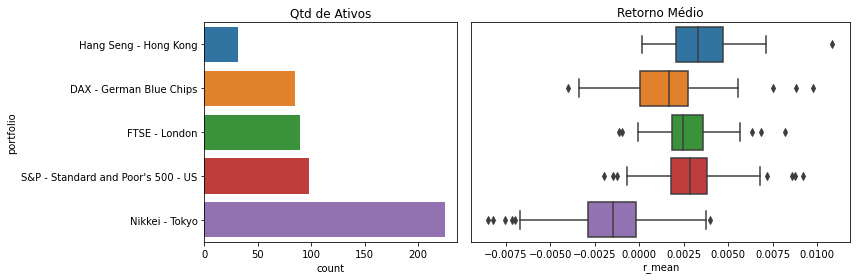

In [107]:
fig, ax = plt.subplots(1, 2, figsize=(12,4), gridspec_kw={'width_ratios': [1, 1.5]})
sns.countplot(data=df_stats, y='portfolio', ax=ax[0])
ax[0].title.set_text('Qtd de Ativos')
sns.boxplot(data=df_stats, y='portfolio', x='r_mean', ax=ax[1])
ax[1].title.set_text("Retorno Médio")
ax[1].get_yaxis().set_ticks([])
ax[1].set_ylabel('')
fig.tight_layout()

In [108]:
df_stats[df_stats.port==1].describe().T

,count,mean,std,min,25%,50%,75%,max
port,31.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
i,31.0,16.000000,9.092121,1.000000,8.500000,16.000000,23.500000,31.000000
r_mean,31.0,0.003504,0.002186,0.000141,0.002043,0.003286,0.004725,0.010865
r_std,31.0,0.045723,0.007296,0.035848,0.040043,0.045450,0.050112,0.069105


### Matriz de Covariância

In [109]:
df_cov_mx[df_cov_mx.i!=df_cov_mx.j].describe().T

,count,mean,std,min,25%,50%,75%,max
port,37904.0,4.336350,1.068738,1.000000,4.000000,5.000000,5.00000,5.000000
i,37904.0,60.152728,49.736086,1.000000,20.000000,46.000000,88.00000,224.000000
j,37904.0,120.305456,62.150969,2.000000,68.000000,113.000000,178.00000,225.000000
cov,37904.0,0.388782,0.166550,-0.145815,0.258983,0.419793,0.51717,0.909412


<AxesSubplot:>

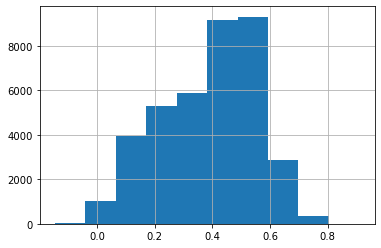

In [110]:
df_cov_mx[df_cov_mx.i!=df_cov_mx.j]['cov'].hist()

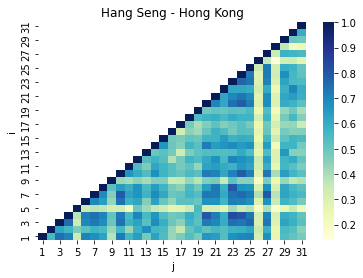

In [111]:
portfolio = 1
df_cov_pivot = df_cov_mx[df_cov_mx.port==portfolio].pivot(index='i', columns='j', values='cov')
sns.heatmap(df_cov_pivot.iloc[::-1], cmap="YlGnBu") 
plt.title(portfolios[portfolio])
ax=ax

### Fronteiras de Eficiência Irrestrira - UEF

In [112]:
uef.head()

,mean_return,var_return,port,portfolio
0,0.010865,0.004776,1,Hang Seng - Hong Kong
1,0.010861,0.004768,1,Hang Seng - Hong Kong
2,0.010857,0.004760,1,Hang Seng - Hong Kong
3,0.010853,0.004752,1,Hang Seng - Hong Kong
4,0.010849,0.004745,1,Hang Seng - Hong Kong


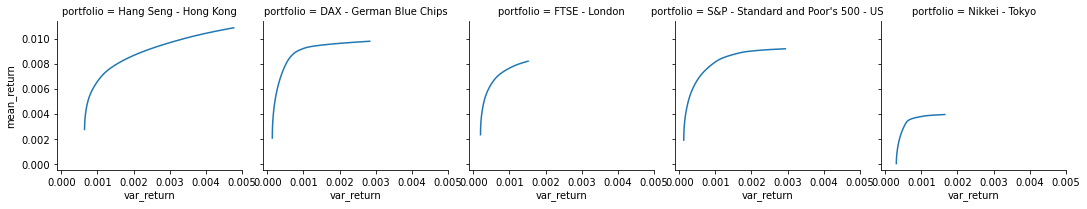

In [113]:
g = sns.relplot(data=uef, y='mean_return', x='var_return', col='portfolio', kind='line', height=3)
ax=ax

## Curvas de Aprendizado

In [136]:
all_data = all_data[all_data.n_port==1]

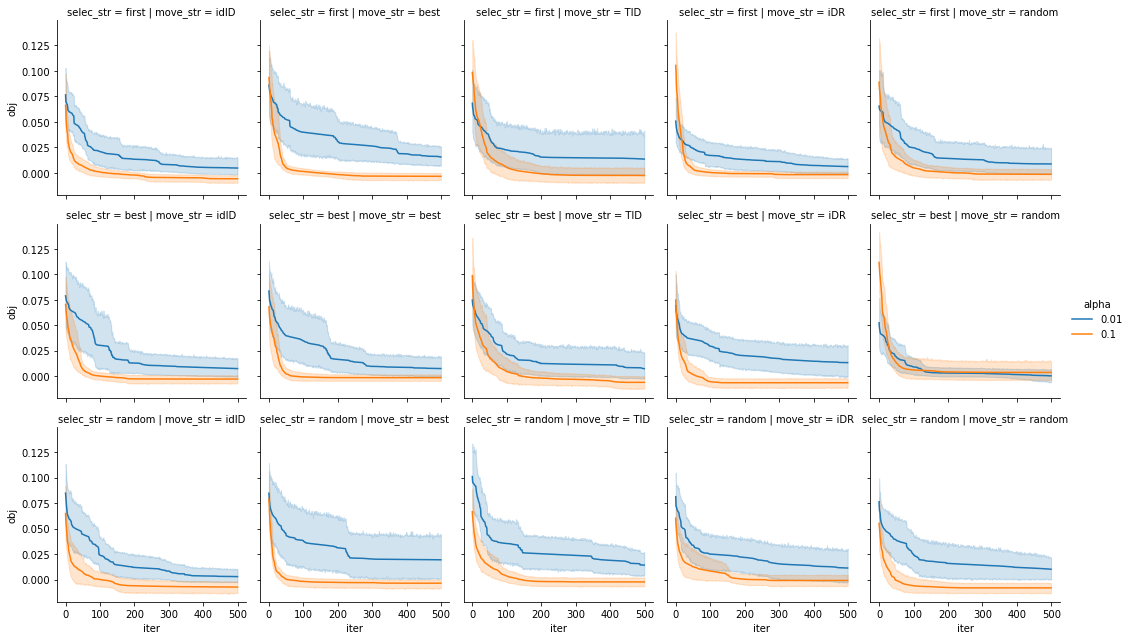

In [133]:
g = sns.FacetGrid(
    data=all_data, col='move_str', row='selec_str', hue='alpha')
g.map(sns.lineplot, 'iter', 'obj')
g.add_legend()
g=g

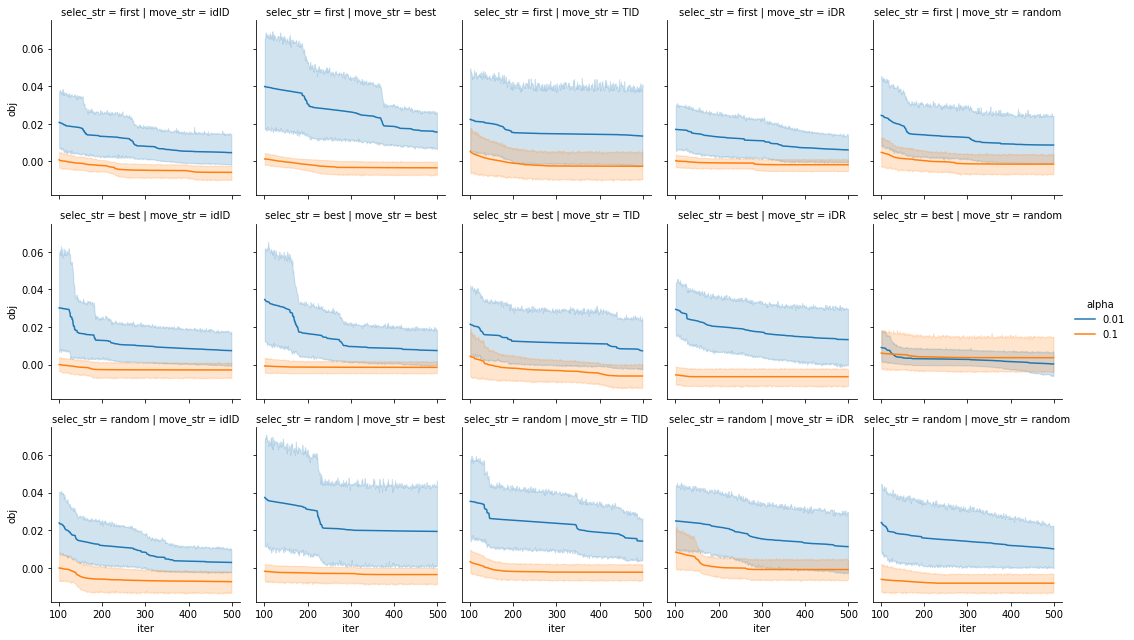

In [134]:
g = sns.FacetGrid(
    data=all_data[all_data.iter>100], col='move_str', row='selec_str', hue='alpha')
g.map(sns.lineplot, 'iter', 'obj')
g.add_legend()
g=g

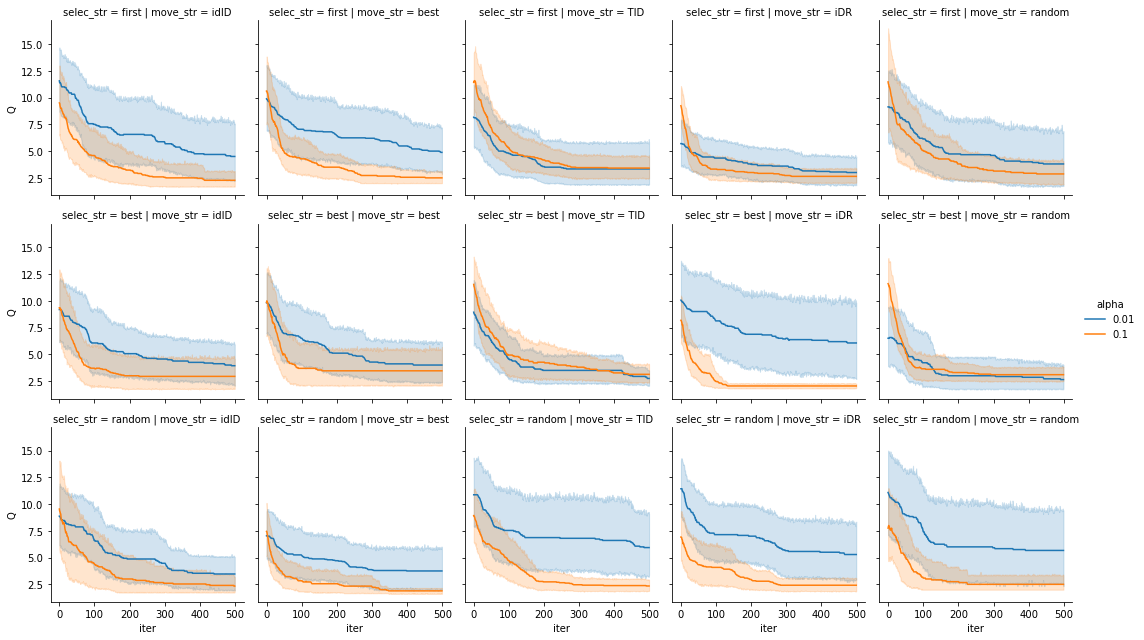

In [135]:
g = sns.FacetGrid(
    data=all_data, col='move_str', row='selec_str', hue='alpha')
g.map(sns.lineplot, 'iter', 'Q')
g.add_legend()
g=g

## Análise Best - Portfólio 1

In [116]:
df_stats[df_stats.port==1].describe().T

,count,mean,std,min,25%,50%,75%,max
port,31.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
i,31.0,16.000000,9.092121,1.000000,8.500000,16.000000,23.500000,31.000000
r_mean,31.0,0.003504,0.002186,0.000141,0.002043,0.003286,0.004725,0.010865
r_std,31.0,0.045723,0.007296,0.035848,0.040043,0.045450,0.050112,0.069105


In [117]:
print(best_data.shape)
best_data.drop(['X', 'Z',],axis=1,).head()

(270000, 18)


,iter,obj,aug_obj,return,Q,max_iter,neighbours,alpha,exp_return,n_port,k,move_str,seed,selec_str,filename,last_iter
0,0,-0.0037,-0.0037,-0.0037,1.0,500,100,0.1,0.0025,5,1,idID,55,first,log_gls_20211117_212358_048149.csv,1
1,1,-0.0037,-0.0037,-0.0037,1.0,500,100,0.1,0.0025,5,1,idID,55,first,log_gls_20211117_212358_048149.csv,1
2,2,-0.0037,-0.0037,-0.0037,1.0,500,100,0.1,0.0025,5,1,idID,55,first,log_gls_20211117_212358_048149.csv,1
3,3,-0.0037,-0.0037,-0.0037,1.0,500,100,0.1,0.0025,5,1,idID,55,first,log_gls_20211117_212358_048149.csv,1
4,4,-0.0037,-0.0037,-0.0037,1.0,500,100,0.1,0.0025,5,1,idID,55,first,log_gls_20211117_212358_048149.csv,1


In [118]:
best_data.describe().T

,count,mean,std,min,25%,50%,75%,max
iter,270000.0,249.500000,144.337546,0.000000,124.750000,249.500000,374.250000,499.000000
obj,270000.0,0.010645,0.034267,-0.038199,-0.001130,0.001104,0.005722,0.263674
aug_obj,270000.0,0.010645,0.034267,-0.038199,-0.001130,0.001104,0.005722,0.263674
return,270000.0,0.002964,0.002191,-0.004002,0.001618,0.002683,0.004033,0.010827
Q,270000.0,4.397141,4.810295,1.000000,2.000000,2.000000,5.000000,30.000000
max_iter,270000.0,500.000000,0.000000,500.000000,500.000000,500.000000,500.000000,500.000000
neighbours,270000.0,100.000000,0.000000,100.000000,100.000000,100.000000,100.000000,100.000000
alpha,270000.0,0.057667,0.044921,0.010000,0.010000,0.100000,0.100000,0.100000
exp_return,270000.0,0.002442,0.001943,0.000500,0.001000,0.002000,0.003000,0.010000
n_port,270000.0,2.527778,1.231219,1.000000,1.000000,3.000000,4.000000,5.000000


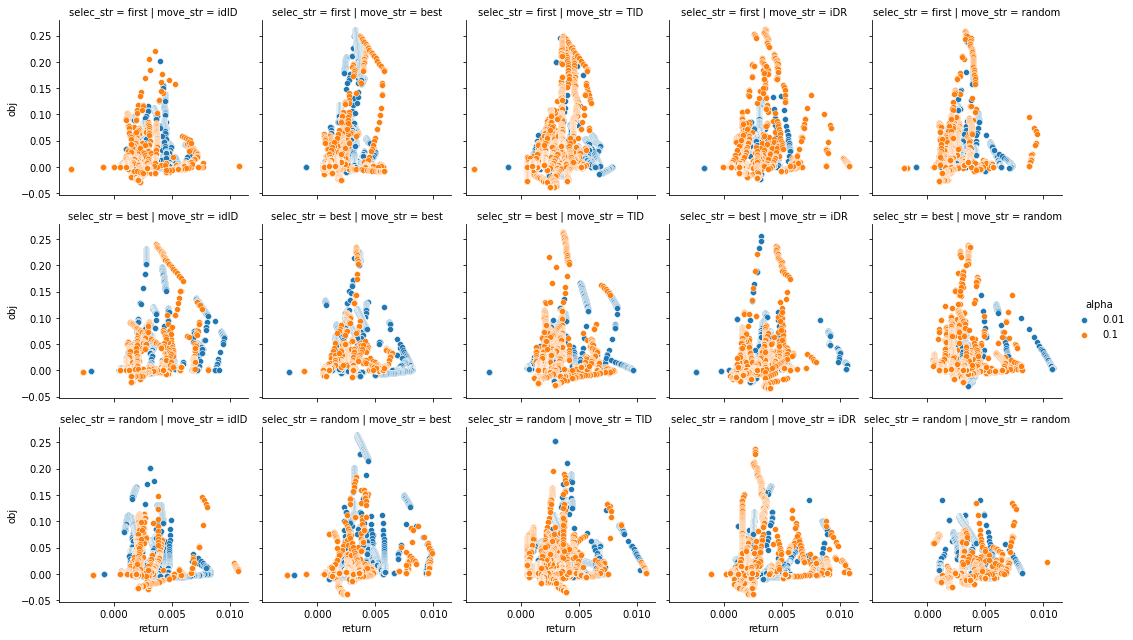

In [119]:
g = sns.FacetGrid(data=best_data, col='move_str', row='selec_str', hue='alpha')
g.map(sns.scatterplot, 'return', 'obj')
g.add_legend()
g=g

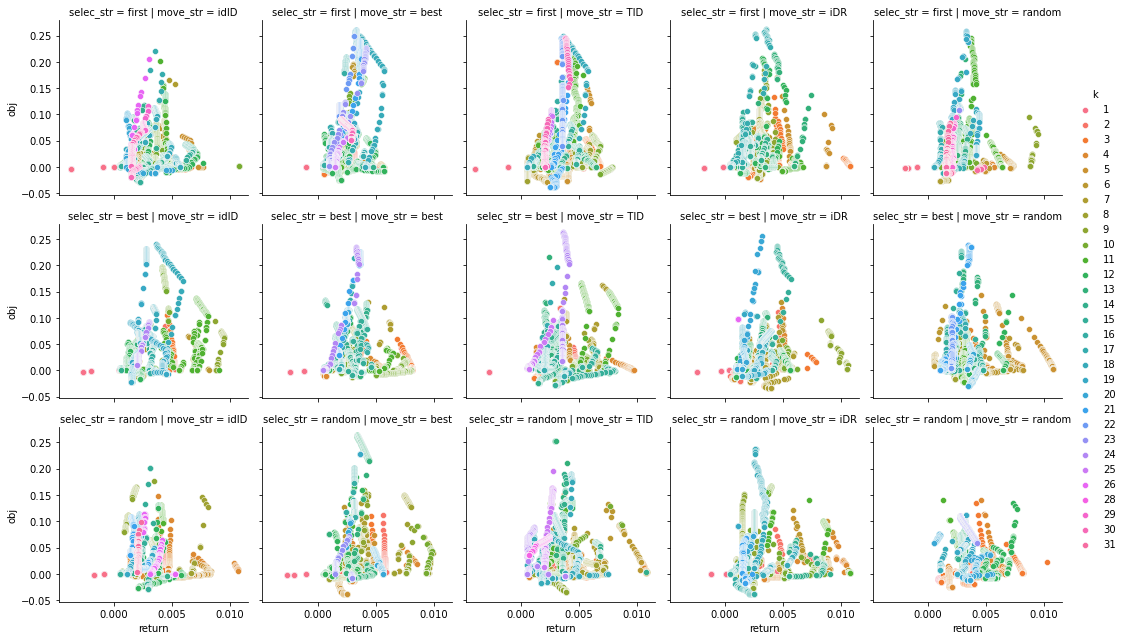

In [120]:
g = sns.FacetGrid(data=best_data, col='move_str', row='selec_str', hue='k')
g.map(sns.scatterplot, 'return', 'obj')
g.add_legend()
g=g

In [121]:
best_data.describe().T

,count,mean,std,min,25%,50%,75%,max
iter,270000.0,249.500000,144.337546,0.000000,124.750000,249.500000,374.250000,499.000000
obj,270000.0,0.010645,0.034267,-0.038199,-0.001130,0.001104,0.005722,0.263674
aug_obj,270000.0,0.010645,0.034267,-0.038199,-0.001130,0.001104,0.005722,0.263674
return,270000.0,0.002964,0.002191,-0.004002,0.001618,0.002683,0.004033,0.010827
Q,270000.0,4.397141,4.810295,1.000000,2.000000,2.000000,5.000000,30.000000
max_iter,270000.0,500.000000,0.000000,500.000000,500.000000,500.000000,500.000000,500.000000
neighbours,270000.0,100.000000,0.000000,100.000000,100.000000,100.000000,100.000000,100.000000
alpha,270000.0,0.057667,0.044921,0.010000,0.010000,0.100000,0.100000,0.100000
exp_return,270000.0,0.002442,0.001943,0.000500,0.001000,0.002000,0.003000,0.010000
n_port,270000.0,2.527778,1.231219,1.000000,1.000000,3.000000,4.000000,5.000000


In [122]:
df_stats[df_stats.port==1].describe().T

,count,mean,std,min,25%,50%,75%,max
port,31.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
i,31.0,16.000000,9.092121,1.000000,8.500000,16.000000,23.500000,31.000000
r_mean,31.0,0.003504,0.002186,0.000141,0.002043,0.003286,0.004725,0.010865
r_std,31.0,0.045723,0.007296,0.035848,0.040043,0.045450,0.050112,0.069105


In [123]:
uef[uef.port==1].describe().T

,count,mean,std,min,25%,50%,75%,max
mean_return,2000.0,0.006825,0.002334,0.002784,0.004804,0.006825,0.008845,0.010865
var_return,2000.0,0.001579,0.001116,0.000642,0.000716,0.001058,0.002150,0.004776
port,2000.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0, 0.5, 'mean_return')

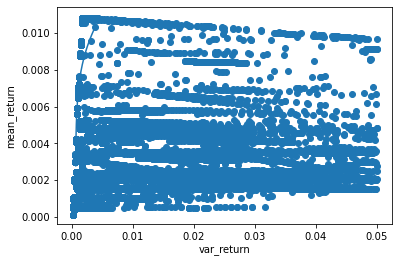

In [124]:
data = best_data[best_data['obj']<0.05]
data = data[data.n_port==1]
plt.plot(uef[uef.port==1].var_return, uef[uef.port==1].mean_return)
plt.scatter(data.obj, data['return'])
plt.xlabel("var_return")
plt.ylabel("mean_return")

In [125]:
best_data.describe().T

,count,mean,std,min,25%,50%,75%,max
iter,270000.0,249.500000,144.337546,0.000000,124.750000,249.500000,374.250000,499.000000
obj,270000.0,0.010645,0.034267,-0.038199,-0.001130,0.001104,0.005722,0.263674
aug_obj,270000.0,0.010645,0.034267,-0.038199,-0.001130,0.001104,0.005722,0.263674
return,270000.0,0.002964,0.002191,-0.004002,0.001618,0.002683,0.004033,0.010827
Q,270000.0,4.397141,4.810295,1.000000,2.000000,2.000000,5.000000,30.000000
max_iter,270000.0,500.000000,0.000000,500.000000,500.000000,500.000000,500.000000,500.000000
neighbours,270000.0,100.000000,0.000000,100.000000,100.000000,100.000000,100.000000,100.000000
alpha,270000.0,0.057667,0.044921,0.010000,0.010000,0.100000,0.100000,0.100000
exp_return,270000.0,0.002442,0.001943,0.000500,0.001000,0.002000,0.003000,0.010000
n_port,270000.0,2.527778,1.231219,1.000000,1.000000,3.000000,4.000000,5.000000


In [126]:
best_data['min_obj'] = best_data.groupby(['exp_return', 'k'], as_index=False)['obj'].transform(min)
best_best_data = best_data[best_data.obj==best_data.min_obj]
print(best_best_data.shape)

(65195, 19)


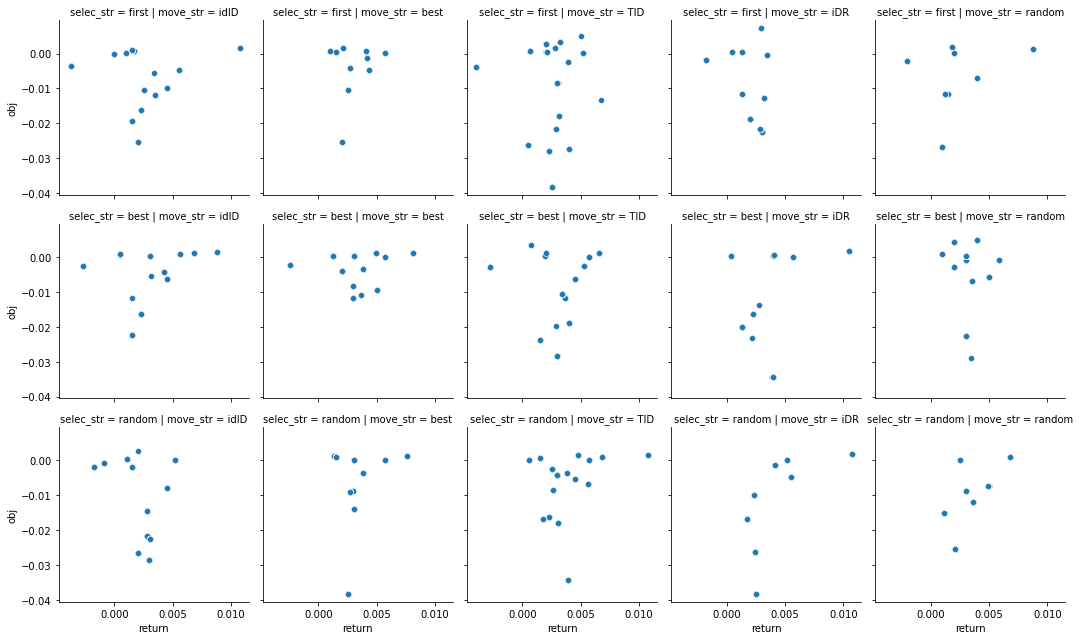

In [127]:
g = sns.FacetGrid(data=best_best_data[best_best_data.obj<0.01], col='move_str', row='selec_str')
g.map(sns.scatterplot, 'return', 'obj')
g.add_legend()
g=g

Text(0, 0.5, 'mean_return')

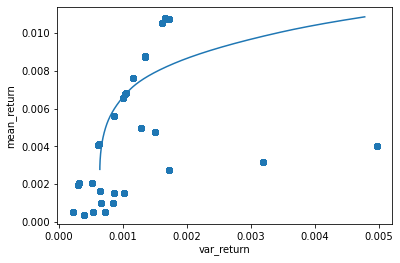

In [128]:
port = 1
data = best_best_data[best_best_data.n_port==port]
data = data[data['obj']<0.005]
plt.plot(uef[uef.port==port].var_return, uef[uef.port==port].mean_return)
plt.scatter(data.obj, data['return'])
plt.xlabel("var_return")
plt.ylabel("mean_return")

In [129]:
best_data.groupby(['exp_return', 'move_str', 'selec_str'], as_index=False)['obj']\
    .count()\
    .pivot(index=['move_str', 'selec_str'], columns='exp_return', values='obj')

exp_return          0.0005  0.0010  0.0015  0.0020  0.0025  0.0030  0.0035  \
move_str selec_str                                                           
TID      best       2000.0  1000.0  3500.0  3500.0  1000.0   500.0  2000.0   
         first      2500.0  4000.0  2000.0  3000.0  2500.0  1000.0  1500.0   
         random     4000.0  2000.0  2500.0  2500.0  1000.0  1500.0  1000.0   
best     best       2500.0  3000.0  2500.0  2000.0  1000.0  1500.0     NaN   
         first      3500.0  4000.0  4500.0  3000.0  3000.0   500.0   500.0   
         random     2500.0  5000.0  3000.0  2000.0  1500.0  3500.0  1000.0   
iDR      best       2000.0  3000.0  3500.0  2500.0  1500.0  1500.0  1500.0   
         first      3000.0  2500.0  3000.0  3000.0  2000.0  4000.0   500.0   
         random     4000.0  2000.0  4000.0  2000.0  3000.0   500.0   500.0   
idID     best       1500.0  2000.0  2500.0  1000.0  2500.0  1000.0  1500.0   
         first      1500.0  3000.0  3000.0  2500.0  3500.0  1000.0  1000.0   
         random     4500.0  2500.0  2000.0  2000.0   500.0  1000.0     NaN   
random   best       2500.0  3000.0  2500.0  3500.0   500.0  1000.0  1000.0   
         first      1500.0  3000.0  2500.0  2500.0  1000.0   500.0  1000.0   
         random     2000.0  2000.0   500.0  2000.0  2500.0  2000.0     NaN   

exp_return          0.0040  0.0045  0.0050  0.0055  0.0060  0.0065  0.0070  \
move_str selec_str                                                           
TID      best        500.0  1000.0     NaN     NaN   500.0     NaN     NaN   
         first      1000.0   500.0  1000.0     NaN  1500.0     NaN     NaN   
         random      500.0  1000.0   500.0  1500.0  1000.0     NaN   500.0   
best     best       1000.0     NaN  1000.0     NaN     NaN     NaN     NaN   
         first      1000.0     NaN   500.0     NaN     NaN     NaN     NaN   
         random      500.0     NaN  1000.0     NaN  1000.0     NaN     NaN   
iDR      best       2000.0     NaN     NaN     NaN   500.0     NaN     NaN   
         first      2000.0   500.0     NaN  1000.0     NaN     NaN     NaN   
         random      500.0     NaN   500.0   500.0     NaN   500.0     NaN   
idID     best       1000.0   500.0   500.0     NaN     NaN   500.0   500.0   
         first         NaN   500.0     NaN   500.0   500.0   500.0     NaN   
         random        NaN  1000.0     NaN     NaN     NaN     NaN     NaN   
random   best        500.0  1000.0  1000.0     NaN     NaN     NaN   500.0   
         first      1000.0   500.0     NaN   500.0     NaN     NaN     NaN   
         random      500.0     NaN   500.0     NaN     NaN     NaN     NaN   

exp_return          0.0075  0.0080  0.0085  0.0090  0.0095  0.0100  
move_str selec_str                                                  
TID      best          NaN     NaN     NaN     NaN     NaN     NaN  
         first         NaN     NaN     NaN     NaN     NaN   500.0  
         random      500.0     NaN     NaN     NaN   500.0     NaN  
best     best        500.0     NaN     NaN     NaN   500.0     NaN  
         first         NaN     NaN   500.0   500.0     NaN     NaN  
         random        NaN     NaN     NaN     NaN     NaN     NaN  
iDR      best          NaN     NaN     NaN  1000.0     NaN     NaN  
         first         NaN     NaN   500.0   500.0     NaN     NaN  
         random        NaN   500.0     NaN     NaN   500.0     NaN  
idID     best          NaN  1000.0     NaN     NaN   500.0     NaN  
         first         NaN  1000.0     NaN     NaN   500.0     NaN  
         random        NaN   500.0   500.0   500.0     NaN     NaN  
random   best          NaN     NaN     NaN     NaN     NaN     NaN  
         first       500.0   500.0     NaN     NaN     NaN     NaN  
         random        NaN     NaN     NaN     NaN     NaN     NaN

In [130]:
best_data.groupby(['exp_return', 'move_str', 'selec_str'], as_index=False)['obj']\
    .min()\
    .pivot(index=['move_str', 'selec_str'], columns='exp_return', values='obj')

exp_return            0.0005    0.0010    0.0015    0.0020    0.0025  \
move_str selec_str                                                     
TID      best      -0.019620 -0.002368 -0.028474 -0.011638 -0.010469   
         first     -0.028041 -0.017944 -0.001331 -0.038199 -0.021606   
         random    -0.034247 -0.004182 -0.017934 -0.008549  0.000069   
best     best      -0.010484 -0.003537  0.000069 -0.010779  0.000069   
         first     -0.013135  0.000013 -0.025310 -0.004818 -0.010537   
         random    -0.038193 -0.014395 -0.008738  0.000069  0.000199   
iDR      best      -0.019977 -0.016208 -0.011490 -0.023117 -0.013715   
         first     -0.011541 -0.021611 -0.021612 -0.022506 -0.012848   
         random    -0.038197 -0.026246 -0.016684 -0.010470  0.000045   
idID     best       0.000720 -0.016204 -0.022194  0.010394 -0.005485   
         first     -0.028041 -0.016210 -0.019419 -0.025305 -0.010547   
         random    -0.028478 -0.014395 -0.005014 -0.026564  0.000044   
random   best      -0.022498 -0.002961 -0.029027 -0.001991  0.000011   
         first     -0.008990 -0.026637 -0.011494  0.000025  0.022410   
         random    -0.025307 -0.015179  0.001021 -0.008601 -0.008741   

exp_return            0.0030    0.0035    0.0040    0.0045    0.0050  \
move_str selec_str                                                     
TID      best      -0.018950 -0.006226  0.002372 -0.002625       NaN   
         first     -0.008405  0.000043 -0.027272  0.048339 -0.004002   
         random     0.000072  0.001501  0.001390 -0.005226  0.070422   
best     best      -0.011869       NaN -0.001126       NaN -0.009511   
         first      0.053923  0.000629  0.000069       NaN  0.003050   
         random    -0.013894  0.000667  0.001902       NaN  0.001167   
iDR      best      -0.034246 -0.034257  0.000069       NaN       NaN   
         first      0.001055 -0.000539  0.001981 -0.001765       NaN   
         random     0.000070  0.002838 -0.001236       NaN -0.007241   
idID     best       0.000859  0.000647 -0.004424  0.001344  0.000069   
         first     -0.001439 -0.004625       NaN -0.010006       NaN   
         random     0.001087       NaN       NaN -0.007828       NaN   
random   best      -0.000787 -0.006863  0.004966  0.000989 -0.005819   
         first      0.003186  0.001855 -0.007100 -0.007380       NaN   
         random    -0.018950       NaN -0.007378       NaN  0.001040   

exp_return            0.0055    0.0060    0.0065    0.0070    0.0075  \
move_str selec_str                                                     
TID      best            NaN  0.001005       NaN       NaN       NaN   
         first           NaN -0.013426       NaN       NaN       NaN   
         random    -0.006864  0.000664       NaN  0.001487  0.000686   
best     best            NaN       NaN       NaN       NaN -0.002406   
         first           NaN       NaN       NaN       NaN       NaN   
         random          NaN  0.001441       NaN       NaN       NaN   
iDR      best            NaN  0.001378       NaN       NaN       NaN   
         first      0.002534       NaN       NaN       NaN       NaN   
         random    -0.004728       NaN  0.001726       NaN       NaN   
idID     best            NaN       NaN  0.000449 -0.002646       NaN   
         first     -0.004757  0.004033  0.002172       NaN       NaN   
         random          NaN       NaN       NaN       NaN       NaN   
random   best            NaN       NaN       NaN  0.002338       NaN   
         first      0.001853       NaN       NaN       NaN  0.001345   
         random          NaN       NaN       NaN       NaN       NaN   

exp_return            0.0080    0.0085    0.0090    0.0095    0.0100  
move_str selec_str                                                    
TID      best            NaN       NaN       NaN       NaN       NaN  
         first           NaN       NaN       NaN       NaN  0.003186  
         random          NaN       NaN   

In [131]:
best_best_data = best_data.groupby(['exp_return'], as_index=False)['obj'].min()
print(best_best_data.shape)
best_best_data.head()

(20, 2)


,exp_return,obj
0,0.0005,-0.038197
1,0.0010,-0.026637
2,0.0015,-0.029027
3,0.0020,-0.038199
4,0.0025,-0.021606


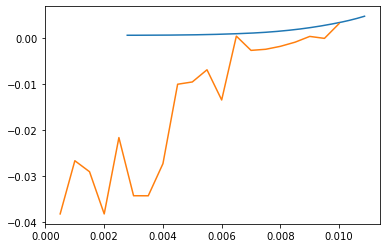

In [132]:
plt.plot(uef[uef.port==1].mean_return, uef[uef.port==1].var_return)
plt.plot(best_best_data.exp_return, best_best_data.obj)